# Logistic Regression

Suppose $Y$ is a Bernoulli random variable where

$$ P(Y=1) = p \qquad \text{ and } \qquad P(Y=0)=1-p. $$

The logistic model assumes that 

$$ p = \displaystyle\frac{\text{exp}(a^Tu + b)}{1+\text{exp}(a^Tu+b)} $$

where $u \in \mathbb{R}^n$ is a vector of explanatory variables and $a \in \mathbb{R}^n$ and $b \in \mathbb{R}$ are model parameters. 

Suppose we have training data $(u_1, y_1), ... , (u_m, y_m)$ where the $u_i$ are observations of the explanatory variables and $y_i \in \{0,1\}$. To fit the model, we want to find the MLE of the model parameters $a \in \mathbb{R}^n$ and $b \in \mathbb{R}$.

The likelihood function is

$$ \left(\prod_{i=1}^m p_i^{y_i}\right)\left(\prod_{i=1}^m (1-p_i)^{1 - y_i}\right) $$

where $p_i = \displaystyle\frac{\text{exp}(a^Tu_i + b)}{1+\text{exp}(a^Tu_i+b)}$.

We could re-write the likelihood by first re-ordering the training observations so that for $1 \leq i \leq q$, $y_i=1$ and for $q+1 \leq i \leq m$, $y_i=0$. Then, the likelihood can be written

$$\left(\prod_{i=1}^q p_i\right)\left(\prod_{i=q+1}^m (1-p_i)\right). $$

We will maximize the log likelihood. Note that

$$ 1 - p_i =  \displaystyle\frac{1}{1+\text{exp}(a^Tu+b)} $$

The log likelihood is

\begin{align*}
\displaystyle\sum_{i=1}^m y_i\log(p_i) + \displaystyle\sum_{i=1}^m (1-y_i)\log(1- p_i) & = \displaystyle\sum_{i=1}^m y_i(a^Tu_i+b) -  \displaystyle\sum_{i=1}^m \log(1+\text{exp}(a^Tu_i+b)) 
 \end{align*}
 
Let $U$ be the design matrix, where the rows of $U$ the row vectors $u_i^T$ and we append a column of 1's to fit the intercept. Re-write the log likelihood as 

$$\displaystyle\sum_{i=1}^m y_i([Uz]_i) -  \displaystyle\sum_{i=1}^m \log(1+\text{exp}([Uz]_i)) $$

where $z$ is a $n+1$ vector whose first $n$ entries represent the vector $a$ and the last entry represents the intercept $b$ and where $[Uz]_i$ represents the $i$th entry of the vector. 

Our goal is to minimize

$$ - \displaystyle\sum_{i=1}^m y_i([Uz]_i) + \displaystyle\sum_{i=1}^m \log(1+\text{exp}([Uz]_i)) $$

We can also introduce a regularization term:

$$ - \displaystyle\sum_{i=1}^m y_i([Uz]_i) + \displaystyle\sum_{i=1}^m \log(1+\text{exp}([Uz]_i)) + \frac{\lambda}{2} \cdot \displaystyle\sum_{i=1}^n z_i \$$

Note that we do not include the last entry of the vector $z$ in the penalty term since the intercept is typically not penalized.



In [1]:
import numpy as np

In [2]:
# generate test data
n = 5 # number of explanatory variables plus the intercept
m = 2000 # number of data points
real_z = 10*np.random.uniform(-1,1,n) # last entry of z represents the intercept
real_z

array([-8.95011088, -5.96973417, -2.81492601, -2.09489097, -5.72386906])

In [3]:
# design matrix
U = np.concatenate([np.random.beta(2,5,(m,1)), np.random.normal(1,0.25, (m,1)), 
                    np.random.binomial(1,0.7,(m,1)), np.random.uniform(-2,2,(m,1)),
                   np.ones((m,1))], axis=1)
# stable sigmoid function, will avoid overflow in exp
def sig(x):
    return np.piecewise(x, [x >= 0], [lambda i: 1 / (1 + np.exp(-i)), lambda i: np.exp(i) / (1 + np.exp(i))])
p_train = sig(U@real_z + np.random.normal(0,5,m)) # the additional random component is to add some noise
y_train = np.array([0 if p_train[i] <0.5 else 1 for i in range(len(p_train))])
y_train[:200] = (y_train[:200] + 1) % 2 # outliers
print('The proportion of Class 1 observations in training data is', y_train.mean())

The proportion of Class 1 observations in training data is 0.1035


In [4]:
def nll(z, U, y):
    return np.sum(np.log(1+np.exp(U@z))) - y@(U@z)
def l2_norm(x):
    return np.sqrt(np.sum(x**2))
def grad(z, U, y, gamma = 0):
    return U.T@(sig(U@z) - y) + gamma*np.append(z[:-1],0)  # U.T@sig(U@z) - U.T@y 
# Backtracking line search requires that the NLL be evaluated - this will cause overflow in exp
def check_grad(z,U,y):
    return np.sum(np.dot(np.diag(sig(U@z) - y), U), axis=0)
def backtrack(obj, z, U, y, alpha, beta, grad, descent_direction):
    t = 1
    while obj(z+t*descent_direction, U, y) > obj(z,U,y) + t*alpha*grad@descent_direction:
        t = t*beta
    return t

In [5]:
# Gradient Descent
# use learning schedule instead of backtracking line search
z_gd = np.zeros(n) # initial point
tol = 1e-8 # stopping criterion tolerance for L2 norm of gradient
max_iter = 1000
i = 0
gamma = 0.0 # regularization 
step_length = 1.0
while i <= max_iter:
    g = grad(z_gd, U, y_train, gamma)
    if l2_norm(g) < tol:
        break
    else:
        z_gd = z_gd - step_length*g # update
        i += 1
        step_length = 1/i          

In [6]:
z_gd

array([-0.18443481, -0.23224705, -0.20626232, -0.0047447 , -1.7344189 ])

In [7]:
probs = sig(U@z_gd)
preds = np.zeros(m)
preds[probs>=0.5] = 1
(preds == y_train).mean()

0.8965

In [8]:
def hessian(z,U, gamma=0):
    P = sig(U@z)
    return U.T@np.diag(P*(1-P))@U + gamma*np.diag(np.append(np.ones(len(z)-1),0.0))

In [9]:
# Newton's Method
z_nm = np.zeros(n)
tol = 1e-8 # stopping criterion tolerance for L2 norm of gradient
max_iter = 100
gamma = 100.0
i = 0
while i <= max_iter:
    g = grad(z_nm,U,y_train, gamma)
    H = hessian(z_nm,U, gamma)
    newton_step = -np.linalg.inv(H)@g
    dec = -g@newton_step
    if dec < tol:
        break
    else:
        z_nm = z_nm+newton_step
    i +=1

In [10]:
z_nm

array([-0.00850714, -0.0241022 , -0.05863496, -0.00343732, -2.09140055])

In [11]:
probs = sig(U@z_nm)
preds = np.zeros(m)
preds[probs>=0.5] = 1
(preds == y_train).mean()

0.8965

In [12]:
U_test = np.concatenate([np.random.beta(2,5,(m,1)), np.random.normal(1,0.25, (m,1)), 
                    np.random.binomial(1,0.7,(m,1)), np.random.uniform(-2,2,(m,1)),
                   np.ones((m,1))], axis=1)
p_test = sig(U_test@real_z + np.random.normal(0,5,m)) # the additional random component is to add some noise
y_test = np.array([0 if p_test[i] <0.5 else 1 for i in range(len(p_test))])

In [13]:
probs = sig(U_test@z_nm)
preds = np.zeros(m)
preds[probs>=0.5] = 1
(preds == y_train).mean()

0.8965

## Example: Plotting Decision Boundary

In [14]:
def newtons_method(U, y, init_point, tol=1e-8, max_iter=100, gamma = 0.0):
    z = init_point
    i=0
    while i <= max_iter:
        g = grad(z,U,y, gamma)
        H = hessian(z,U, gamma)
        newton_step = -np.linalg.inv(H)@g
        dec = -g@newton_step
        if dec < tol:
            break
        else:
            z = z+newton_step
        i +=1
    return z

In [15]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [16]:
m = 200
X = np.concatenate([np.random.beta(2,5,(m,1)), np.random.normal(1,0.25, (m,1)), np.ones((m,1))], axis=1)
z = np.array([-20,5,2])
p = sig(X@z + np.random.normal(0,1,m)) # the additional random component is to add some noise
y = np.array([0 if p[i] <= 0.5 else 1 for i in range(len(p))])
y.mean()

0.67

In [17]:
col = ['red' if y[i]==1 else 'blue' for i in range(len(y))]
fig = go.Figure(data=go.Scatter(x=X[:,0], y=X[:,1], mode='markers', marker=dict(color=col) ))
fig.show()

In [18]:
z_hat = newtons_method(X,y,np.zeros(3))
probs = sig(X@z_hat)
preds = np.zeros(m)
preds[probs>=0.5] = 1
(preds == y).mean()

0.925

In [19]:
col_hat = ['red' if preds[i]==1 else 'blue' for i in range(len(preds))]
cols = [col_hat[i] if preds[i] == y[i] else 'orange' for i in range(len(preds))]
# orange represents the misclassified points
fig = go.Figure(data=go.Scatter(x=X[:,0], y=X[:,1], mode='markers', marker=dict(color=cols) ))
fig.show()

In [20]:
# create a grid of values
xx, yy = np.meshgrid(np.linspace(np.min(X[:,0])-0.1, np.max(X[:,0])+0.1, 100),
                     np.linspace(np.min(X[:,1])-0.1, np.max(X[:,1])+0.1, 100))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_1 = np.concatenate([grid, np.ones(10000).reshape(10000,1)], axis =1)
cont = sig(grid_1@z_hat) - 0.5
cont = cont.reshape(xx.shape)

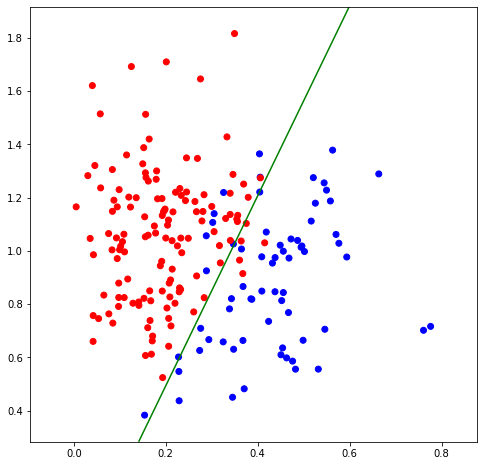

In [21]:
plt.figure(figsize=(8,8))
plt.scatter(x=X[:,0], y=X[:,1],facecolors= col)
plt.contour(xx, yy, cont, levels=[0.0], colors='green') #decision boundary
plt.show()
plt.close()